# Model Building

better to plot with scatter plot, but many features so plot several scatter of one variable feature with all others kept constant

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random
from sklearn.metrics import mean_squared_error
import sklearn.metrics as sm
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from numpy import arange
from pandas import read_csv
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Drop first column of dataframe
def drop_first_col(df):
    return df.iloc[: , 1:]

X_train_20 = pd.read_csv("dataset\X_train_str_20.csv")
X_test_20 = pd.read_csv("dataset\X_test_str_20.csv")
y_train_20 = pd.read_csv("dataset\y_train_str_20.csv")
y_test_20 = pd.read_csv("dataset\y_test_str_20.csv")

X_train_40 = pd.read_csv("dataset\X_train_str_40.csv")
X_test_40 = pd.read_csv("dataset\X_test_str_40.csv")
y_train_40 = pd.read_csv("dataset\y_train_str_40.csv")
y_test_40 = pd.read_csv("dataset\y_test_str_40.csv")

X_train_20 = drop_first_col(X_train_20)
X_test_20 = drop_first_col(X_test_20)
y_train_20 = drop_first_col(y_train_20)
y_test_20 = drop_first_col(y_test_20)

X_train_40 = drop_first_col(X_train_40)
X_test_40 = drop_first_col(X_test_40)
y_train_40 = drop_first_col(y_train_40)
y_test_40 = drop_first_col(y_test_40)

## Test on single simple models

### Create average slope model to check if a tested model performs well

In [18]:
def avg_slope(y_train,y_test,model_predicts,model_name):
    avg_slope = mean(pd.concat([y_train, y_test], axis=0)).iloc[0]
    y_mean = np.full(shape=len(y_test),fill_value=avg_slope,dtype=np.float)
    
    print("FOR AVG SLOPE MODEL:")
    print("RMSE =", math.sqrt(mean_squared_error(y_test, y_mean)))
    print("MAE =", mean_absolute_error(y_test, y_mean))
    
    plt.scatter(model_predicts,y_test)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Scatter plot of '+(model_name+' predictions')+' vs true values')
    plt.ylabel('True values')
    plt.xlabel((model_name+' predictions'))
    plt.show()

Note that the average slope = -0.3098372786175398

### Single XGB Regressor (with no hyperparameters selection)

In [5]:
def check_acc(X_train,y_train,X_test,y_test,model):
    model.fit(X_train,y_train)
    y_predicted = model.predict(X_test)

    print("RMSE =", math.sqrt(mean_squared_error(y_test, y_predicted)))
    print("MAE =", mean_absolute_error(y_test, y_predicted), 2)
    
    plt.plot(y_test, label="original")
    plt.plot(y_predicted, label="predicted")
    plt.ylabel('Decline slope')
    plt.xlabel('Patients')
    plt.legend()
    plt.show()

    return y_predicted

In [6]:
def XGB_class(X_train, X_test, y_train, y_test):
    clf = xgb.XGBRegressor()
    return check_acc(X_train, y_train, X_test, y_test,clf)

Using 20% as test subset:
RMSE = 0.3009929021770659
MAE = 0.2539320291287223 2


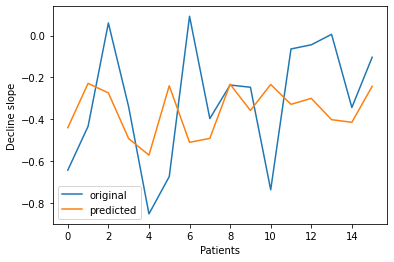

Using 40% as test subset:
RMSE = 0.3047640709792044
MAE = 0.26807980804501663 2


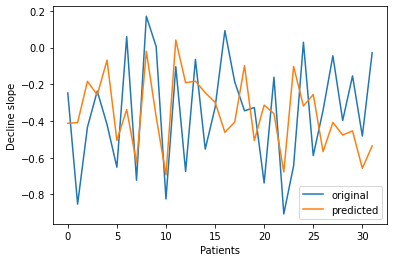

In [14]:
print('Using 20% as test subset:')
y_preds_20_XGB = XGB_class(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
y_preds_40_XGB = XGB_class(X_train_40,X_test_40,y_train_40,y_test_40)

FOR AVG SLOPE MODEL:
RMSE = 0.2880077147883136
MAE = 0.24284431163640055


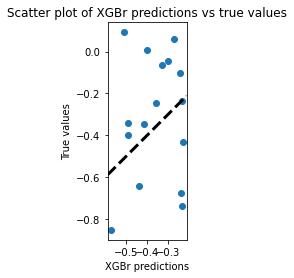

FOR AVG SLOPE MODEL:
RMSE = 0.30103761844517013
MAE = 0.2536486954582603


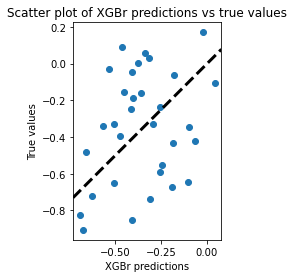

In [19]:
avg_slope(y_train_20,y_test_20,y_preds_20_XGB,'XGBr')
avg_slope(y_train_40,y_test_40,y_preds_40_XGB,'XGBr')

### Simple Linear Regression

Using 20% as test subset:
RMSE = 0.3308101942181599
MAE = 0.26085820265049714 2


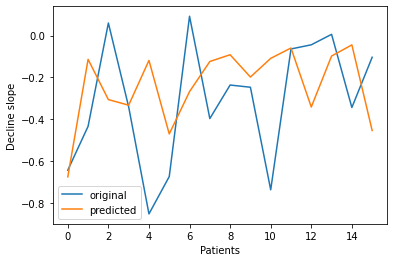

Using 40% as test subset:
RMSE = 0.34261742918625226
MAE = 0.2895144711419033 2


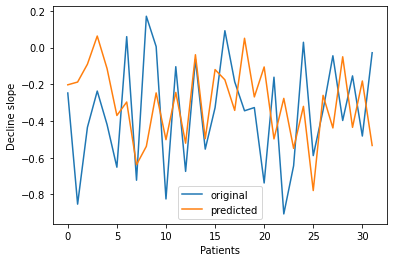

In [9]:
print('Using 20% as test subset:')
y_preds_20_LR = check_acc(X_train_20,y_train_20,X_test_20,y_test_20,LinearRegression())
print('Using 40% as test subset:')
y_preds_40_LR = check_acc(X_train_40,y_train_40,X_test_40,y_test_40,LinearRegression())

FOR AVG SLOPE MODEL:
RMSE = 0.2880077147883136
MAE = 0.24284431163640055


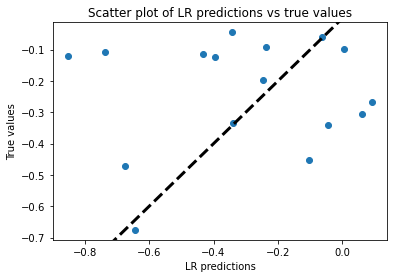

FOR AVG SLOPE MODEL:
RMSE = 0.30103761844517013
MAE = 0.2536486954582603


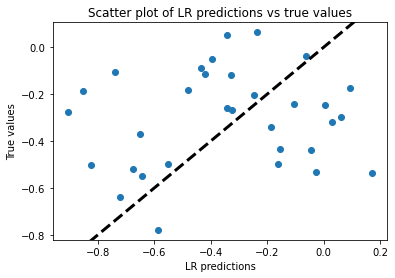

In [10]:
avg_slope(y_train_20,y_test_20,y_preds_20_LR,'LR')
avg_slope(y_train_40,y_test_40,y_preds_40_LR,'LR')

### RFE with XGBRegressor

In [11]:
def rfe_xgb(X_train, y_train,X_test):
    min_features_to_select = 1
    
    clf = xgb.XGBRegressor()
    rfecv = RFECV(estimator=clf,step=3,n_jobs=-1,scoring="r2",cv=5)
    rfecv.fit(X_train, y_train)
    
    #keep selected features + check RFE accuracy scores during running
    newX_train = X_train[X_train.columns[rfecv.support_]]
    newX_test = X_test[X_test.columns[rfecv.support_]]
    print('We kept',newX_train.shape[1],'features out of the',X_train.shape[1])
    
    return newX_train,newX_test

Using 20% as test subset:
We kept 86 features out of the 320
RMSE = 0.30097927210284775
MAE = 0.25377840188210404 2


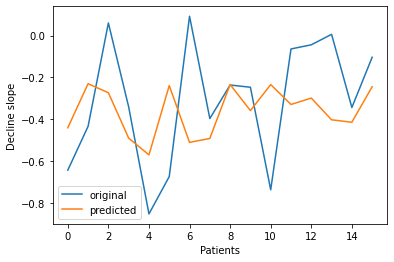

Using 40% as test subset:


KeyboardInterrupt: 

In [12]:
#test rfe then simple XGB classifier
print('Using 20% as test subset:')
newX_train_20,newX_test_20 = rfe_xgb(X_train_20, y_train_20,X_test_20)
XGB_class(newX_train_20,newX_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
newX_train_40,newX_test_40 = rfe_xgb(X_train_40, y_train_40,X_test_40)
XGB_class(newX_train_40,newX_test_40,y_train_40,y_test_40)

## Elastic Net (with hyperparameters)

a penalized linear regression model that includes both the L1 and L2 penalties during training. Using the terminology from “The Elements of Statistical Learning,” a hyperparameter “alpha” is provided to assign how much weight is given to each of the L1 and L2 penalties

In [ ]:
def Elastic_NetCV(X_train, y_train):
    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define model
    ratios = arange(0, 1, 0.1)
    alphas = arange(0, 5, 1)
    model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
    # fit model
    model.fit(X_train, y_train)

    alpha = model.alpha_
    l1_ratio=model.l1_ratio_
    
    return alpha, l1_ratio

In [ ]:
def Elastic_Net(X_train,y_train,X_test,y_test,alpha,l1_ratio):
    #hyperparameters found above:
    print('alpha: %f' % alpha)
    print('l1_ratio: %f' % l1_ratio)

    #play around with parameters to check changes
    alpha-=0
    l1_ratio+=0

    # define model
    model = ElasticNet(alpha = alpha, l1_ratio=l1_ratio)
    check_acc(X_train,y_train,X_test,y_test,model)

In [ ]:
#test rfe then simple XGB classifier
print('Using 20% as test subset:')
alpha_20,l1_ratio_20 = Elastic_NetCV(X_train_20, y_train_20)
Elastic_Net(X_train_20,y_train_20,X_test_20,y_test_20,alpha_20,l1_ratio_20)
print('Using 40% as test subset:')
alpha_40,l1_ratio_40 = Elastic_NetCV(X_train_40, y_train_40)
Elastic_Net(X_train_40,y_train_40,X_test_40,y_test_40,alpha_40,l1_ratio_40)

## Sparse Partial Least Square

Partial least squares regression reduces the number of variables by projecting independent variables onto latent structures. Sparse PLS combines variable selection and modeling in a one-step procedure.

### First find best number of components

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection

def cross_val(X_train,y_train):
    #define cross-validation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    mse = []
    n = len(X_train)
    
    # Calculate MSE with only the intercept
    score = -1*model_selection.cross_val_score(PLSRegression(n_components=1),
               np.ones((n,1)), y_train, cv=cv, scoring='neg_mean_squared_error').mean()    
    mse.append(score)

    # Calculate MSE using cross-validation, adding one component at a time
    for i in np.arange(1, 6):
        pls = PLSRegression(n_components=i)
        score = -1*model_selection.cross_val_score(pls, X_train, y_train, cv=cv,
                   scoring='neg_mean_squared_error').mean()
        mse.append(score)

    #plot test MSE vs. number of components
    plt.plot(mse)
    plt.xlabel('Number of PLS Components')
    plt.ylabel('MSE')
    plt.title('hp')
    
cross_val(X_train_20,y_train_20)
cross_val(X_train_40,y_train_40)
plt.legend(['20%','40%'])

Here, best number of components is 3 in the two situations

In [ ]:
print('Using 20% as test subset:')
pls2_20 = PLSRegression(n_components=3)
check_acc(X_train_20,y_train_20,X_test_20,y_test_20,pls2_20)
print('Using 40% as test subset:')
pls2_40 = PLSRegression(n_components=3)
check_acc(X_train_40,y_train_40,X_test_40,y_test_40,pls2_40)